# SYDE 556/750 --- Assignment 3
**Student ID: 20854840**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
from scipy.integrate import quad
from uuid import uuid4

# Change Seed whenever needed to get reproducible results
seed  = 18945

# Fix the numpy random seed for reproducible results
np.random.seed(seed)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

In [2]:
tauRef = 2 / 1000
tauRc = 20 / 1000

def maxJ(tauRef=tauRef, tauRc=tauRc, maxRate=200):
    return 1 / (1 - np.exp((tauRef - 1 / maxRate) / tauRc))

def gain(jMax=2, e=1, intercept=0):
    return (jMax - 1) / (2 - e * intercept)

def bias(alpha=1, e=1, intercept=0):
    return 1 - alpha * e * intercept

def lifEncode2d(neuron, xy):
    J = neuron.alpha * np.vdot(xy, neuron.circ) + neuron.jBias
    if J > 1:
        return 1 / (tauRef - tauRc * np.log(1 - 1 / J))
    return 0

def printBlock(title, data):
    print(title + " ----------")
    print(data)
    print("-----------------")

def rmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))


def rms(x):
    return np.sqrt(np.mean(np.power(x, 2)))

class Population:
    def __init__(self, numNeurons=1, state=None, neuronOverrides=[]):
        self.numNeurons = numNeurons
        self.rates = []
        self.spikes = []
        if state is None:
            self.defaultNeuronStates = {
                "minRate": 100,
                "maxRate": 200,
                "encoder": [-1, 1],
                "tauRef": 2 / 1000,
                "tauRc": 20 / 1000,
                "minXInt": -2,
                "maxXInt": 2,
            }
        else:
            self.defaultNeuronStates = state
        self.neurons = []
        if not neuronOverrides:
            for idx in range(self.numNeurons):
                neuron = Neuron(self.defaultNeuronStates)
                self.neurons.append(neuron)
        else:
            for neuronOverride in neuronOverrides:
                print("Override Neuron " + str(neuronOverride.getId()))
                self.neurons.append(neuronOverride)

    # Clear all neurons
    def nuke(self):
        self.neurons = []

    # Clear Rates
    def clearRates(self):
        self.rates = []

    def getSpikes(self):
        spikes = []
        for neuron in self.neurons:
            spikes.append(neuron.getSpikeTrend())
        self.spikes = spikes
        return spikes
    
    def spike(self, X, dT, cap=None):
        O = []
        for neuron in self.neurons:
            spikes = neuron.spikey(X, dT)
            O.append(spikes)
        return O

    def getCurves(self, input):
        for neuron in self.neurons:
            self.rates.append(neuron.rates(input))
        return self.rates

    def getNeurons(self):
        return self.neurons

    def getNeuronByIndex(self, idx):
        return self.neurons[idx]

    def getOrderedEncoders(self):
        encoders = []
        for neuron in self.neurons:
            encoders.append(neuron.getEncoder())
        return encoders

    def getNeuronCount(self):
        return len(self.neurons)

    def getNeuronsByRate(self, rateRange=[20, 50], stim=0):
        targetNeurons = []
        for neuron in self.neurons:
            rate = neuron.encode(stim)
            isLessThanMax = rate < rateRange[1]
            isMoreThanMin = rate > rateRange[0]
            if isLessThanMax and isMoreThanMin:
                targetNeurons.append(neuron)
        return targetNeurons
    
    def spikey(self, X, dT):
        num_refSteps = np.floor(self.tauRef/dT)
        spikeCount = 0
        voltages=[]
        refCount = 0
        V = 0
        vNext = 0
        self.spikes=[]
        
        for stimuli in X:
            J = self.alpha*stimuli*self.e+self.jBias
            if refCount > 0:
                V = 0
                refCount -= 1
                self.spikes.append(0)
            else:
                if V >= 1: # Spike everytime the voltage surpases 1
                    V = 1 # Constant spike voltage for the neuron, picked Vth as designer
                    refCount = num_refSteps #+ 1
                    spikeCount +=1
                    self.spikes.append(self.e)
                    V=0
                elif V < 0: # Make sure the voltage is positive, else reset to 0
                    self.spikes.append(0)
                    V = 0
                else: self.spikes.append(0)
            vNext = V + dT*(1/self.tauRc)*(J-V) # Next voltage for spike, derived from core diff equation of LIF
            voltages.append(V)
            V = vNext
            spiked = self.spikes
        return voltages, spikeCount, spiked

class Neuron(Population):
    def __init__(self, state=None, override=None):
        if override is None:
            self.xInt = np.random.uniform(state["minXInt"], state["maxXInt"])
            self.maxRate = np.random.uniform(state["minRate"], state["maxRate"])
            self.e = np.random.choice(state["encoder"])
            self.tauRef = state["tauRef"]
            self.tauRc = state["tauRc"]
            jMax = maxJ(tauRef=self.tauRef, tauRc=self.tauRc, maxRate=self.maxRate)
            self.alpha = gain(jMax, self.e, self.xInt)
            self.jBias = bias(alpha=self.alpha, e=self.e, intercept=self.xInt)
            self.id = uuid4()
            self.spikeTrend = []
            self.firingRates = []
        else:
            self.xInt = override["xInt"]
            self.maxRate = override["maxRate"]
            self.e = override["encoder"]
            self.tauRef = override["tauRef"]
            self.tauRc = override["tauRc"]
            self.alpha = override["alpha"]
            self.jBias = override["jBias"]
            self.id = uuid4()
            self.spikeTrend = override["spikeTrend"]
            self.firingRates = override["firingRates"]

    def whoIsThis(self):
        print(self.__dict)

    def encode(self, x):
        J = self.alpha * x * self.e + self.jBias
        if J > 1:
            return 1 / (self.tauRef - self.tauRc * np.log(1 - 1 / J))
        return 0

    def encodeJ(self, x):
        return self.alpha * x * self.e + self.jBias

    def voltage(self, J, V, dT):
        return V + (dT * (1 / self.tauRc) * (J - V))

    def howManySpikes(self):
        spikePoints = self.spikeTrend[:, 1]
        numSpikes = int(spikePoints.tolist().count(1))
        return numSpikes

    def getIntercept(self):
        return self.xInt

    def getGain(self):
        return self.alpha

    def getBias(self):
        return self.jBias

    def getMaxRate(self):
        return self.maxRate

    def getTauRc(self):
        return self.tauRc

    def getTauRef(self):
        return self.tauRef

    def getId(self):
        return self.id

    def setEncoder(self, encoder):
        self.e = encoder

    def getEncoder(self):
        return self.e

    def me(self):
        return self

    def SetId(self, ied):
        self.id = ied

    def setRate(self, rate):
        self.maxRate = rate

    def setBias(self, bias):
        self.jBias = bias

    def setGain(self, gain):
        self.alpha = gain

    def getSpikeTrend(self):
        return self.spikeTrend

    def getRates(self):
        return self.firingRates

    def rates(self, x):
        self.firingRates = []
        for point in x:
            self.firingRates.append(self.encode(point))
        return self.firingRates

    def clearRates(self):
        self.firingRates = []
        
    def spikey(self, X, dT):
        num_refSteps = np.floor(self.tauRef/dT)
        spikeCount = 0
        voltages=[]
        refCount = 0
        V = 0
        vNext = 0
        self.spikes=[]
        
        for stimuli in X:
            J = self.alpha*stimuli*self.e+self.jBias
            if refCount > 0:
                V = 0
                refCount -= 1
                self.spikes.append(0)
            else:
                if V >= 1: # Spike everytime the voltage surpases 1
                    V = 1 # Constant spike voltage for the neuron, picked Vth as designer
                    refCount = num_refSteps #+ 1
                    spikeCount +=1
                    self.spikes.append(self.e)
                    V=0
                elif V < 0: # Make sure the voltage is positive, else reset to 0
                    self.spikes.append(0)
                    V = 0
                else: self.spikes.append(0)
            vNext = V + dT*(1/self.tauRc)*(J-V) # Next voltage for spike, derived from core diff equation of LIF
            voltages.append(V)
            V = vNext
            spiked = self.spikes
        return voltages, spikeCount, spiked


# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

Text(0.5, 0, '$x $ syimuli')

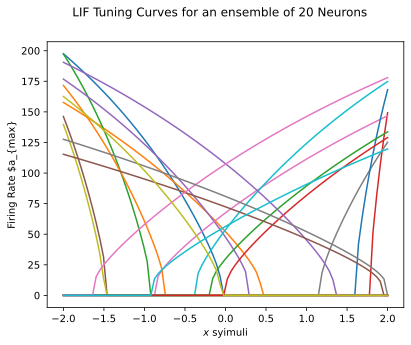

In [3]:
# # Establish number of neurons

# numNeurons = 20

# tauRef = 0.002
# tauRC = 0.020

# # Generate max firing rate that is uniformly distributed with given freqs

# lowFreq = 100
# highFreq = 200
# numSamplesaMax = numNeurons # Getting the number of neurons as samples
# setaMax= np.random.uniform(lowFreq, highFreq, numSamplesaMax)


# # print(setaMax) #--> ignore this is me testing some kernels stuff


# # generate random intercepts (x intercepts b/w given limits)

# minIntercept = -2
# maxIntercept = 2
# numSamplesintercepts = numNeurons
# setIntercept = np.random.uniform(minIntercept, maxIntercept, numSamplesintercepts)

# # print(setIntercept) --> ignore this is me testing some kernels stuff


# def calculateGain(aMax, xIntercept, e, neuronType):
#     if neuronType == "lif" or neuronType == "lif-2d":
#         expTerm = np.exp((tauRef - (1 / aMax)) / (tauRC))
#         return (-expTerm)/((1-expTerm)*(1-xIntercept))
#     return 0

# def calculateBias(xIntercept, e, gain, aMax):
#     expTerm = np.exp((tauRef - (1 / aMax)) / (tauRC))
#     return (1-expTerm-xIntercept)/((1-expTerm)*(1-xIntercept))

# def lifEncode(neuron, x):
#     J = neuron.a * x * neuron.encoderSign + neuron.jBias
#     if J > 1:
#         return 1 / (tauRef - tauRC * np.log(1 - (1 / J)))
#     return 0

#def calculateRMSE(x1, x2):
#    return np.sqrt(np.mean((x1 - x2) ** 2))

# class Neuron:
#     def __init__(self, aMax, xIntercept, id, neuronType):
#         self.id = id
#         self.aMax = aMax
#         self.encoderSign = np.random.choice([-1, 1])
#         a = calculateGain(aMax, xIntercept, self.encoderSign)
#         jBias = calculateBias(xIntercept, self.encoderSign, a, neuronType, aMax)
#         self.a = a
#         self.jBias = jBias
#         self.rate = []

#     def rateAtPoint(self, x, neuronType):
#         if neuronType == "lif":
#             return lifEncode(self, x)

#     def findRate(self, space, neuronType):
#         for element in space:
#             self.rate.append(self.rateAtPoint(element, neuronType))

# # Create neurons
# # Define the number of neurons and other parameters

# lifNeurons = [Neuron(setaMax[i], setIntercept[i], i, "lif") for i in range(numNeurons)]

# # Create a linspace for plotting
# xAxis = np.linspace(-2, 2, 81)

# # Calculate rates for each LIF neuron
# for neuron in lifNeurons:
#     neuron.findRate(xAxis, "lif")

# plt.suptitle("Leaky Integrate-and-Fire (LIF) Neuron Population Tuning Curves")
# for neuron in lifNeurons:
#     neuronRate = neuron.rate
#     plt.plot(xAxis, neuronRate)
# plt.xlabel("Represented value $x$")
# plt.ylabel("Firing Rate (in Hz)")
# plt.show()

# Initialize Number of neurons
numNeurons = 20

# Create state
state = {
    "minRate": 100,
    "maxRate": 200,
    "encoder": [-1, 1],
    "tauRef": 2 / 1000,
    "tauRc": 20 / 1000,
    "minXInt": -2,
    "maxXInt": 2,
}

# Create ensemble of 20 neurons with the states created above
ensemble1 = Population(numNeurons, state)

x = np.linspace(-2,2,90)

tuningCurves = np.array(ensemble1.getCurves(x))

plt.suptitle("LIF Tuning Curves for an ensemble of 20 Neurons")
for curve in tuningCurves:
    plt.plot(x,curve)
plt.ylabel("Firing Rate $a_{max}")
plt.xlabel("$x $ syimuli")


**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

Decoders with noise ----------
[-0.00083555 -0.00110801 -0.00119407  0.00026085 -0.00093479 -0.00060146
  0.00174652  0.00160822 -0.00055926  0.0021599   0.00081757 -0.00103868
  0.00173704  0.00190968 -0.00249237 -0.00106787  0.00189789 -0.00115737
 -0.00069155  0.00141016]
-----------------


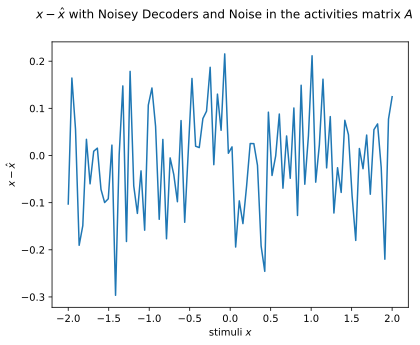

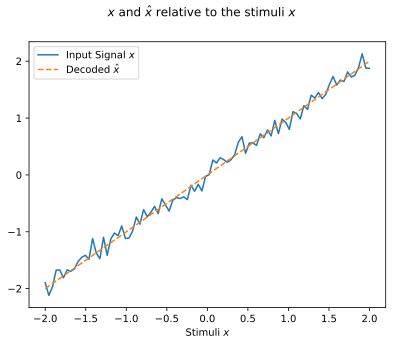

RMSE ----------
0.11087634802791183
-----------------


In [4]:
A = tuningCurves
X = x
noise_stdev = 0.1 * 200
w_noise = np.random.normal(scale=noise_stdev, size=np.shape(A))
A_NOISE = A + w_noise
N = len(X)
n = numNeurons
# find decoders via least squares solution
D = np.linalg.lstsq(
    A @ A.T + N * np.square(noise_stdev) * np.eye(n), A @ X.T, rcond=None
)[0]

printBlock("Decoders with noise", D)

xHat_Noise = np.dot(D, A_NOISE)
X = np.array(X)
E = X - xHat_Noise

plt.figure()
plt.suptitle("$x-\hat{x}$ with Noisey Decoders and Noise in the activities matrix $A$")
plt.plot(X, E)
plt.xlabel("stimuli $x$")
plt.ylabel("$x-\hat{x}$")
# plt.xlim([-2, 2])
plt.show()

plt.figure()
plt.suptitle("$x$ and $\hat{x}$ relative to the stimuli $x$")
plt.plot(X, xHat_Noise, label="Input Signal $x$")
plt.plot(X, X, label="Decoded $\hat{x}$", linestyle="dashed")
# plt.xlim([-2, 2])
plt.legend()
plt.xlabel("Stimuli $x$")
plt.show()

printBlock("RMSE", rmse(X, xHat_Noise))

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

In [5]:
def randComplex():
    return np.random.normal() + np.random.normal() * 1j

#If symmetry exists, it returns a boolean indicating its existence and the index where the symmetric element is located.
def symmetryExists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)

# Calculate signal RMS
def signalRMS(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))

# Calculates the current RMS of the signal and then scales all elements to achieve the desired RMS.
def rescaleSignal(signal, idealRMS):
    currentRMS = signalRMS(signal)
    rescaledSignal = [p * idealRMS / currentRMS for p in signal]
    return rescaledSignal

def locations(index):
    return int(index[0])


# It's a way to ensure that the frequency domain and signal values remain aligned.
def tuplify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))

def calcRmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))

def generate_signal(T, dt, rms, limit, seed):

    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = randComplex()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetryExists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescaleSignal(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = tuplify(F, Z)
    return z, Z


def plot_signal(signal, domain="time", T=1, dt=1/1000, isBandwidth=False):
    t = np.arange(0, T, dt)
    

    signalData = signal["x"] if domain == "time" else signal["X"]
    signalType = "$x(t)$" if domain == "time" else "$x(ω)$"
    freqLabel = str(signal["freq"]) + " Hz bandwidth" if isBandwidth else str(signal["freq"]) + " Hz limit"
    rmsType = "time-domain" if domain == "time" else "frequency-domain"

    plt.figure(figsize=(16,5))
    plt.plot(t, signalData)
    plt.suptitle(f"{signalType} signal with {freqLabel}")
    plt.xlabel("$t$ (sec)" if domain == "time" else "$ω$ Hz.")
    plt.ylabel(signalType)
    plt.xlim([0, T])
    plt.show()


# def post_synaptic_current_filter(t0=0, T=2, dt=1 / 1000, n=0, tau=7 / 1000):
#     t = np.arange(t0, T, dt)
#     N = t.size
#     h = np.array(np.zeros(N))

#     for idx, point in enumerate(h):
#         c = quad(C, 0, np.Inf, args=(n, tau))[0]
#         h[idx] = np.power(c, -1) * np.power(t[idx], n) * np.exp(-t[idx] / tau)
#         if t[idx] < 0:
#             h[idx] = 0
#     # Normalizing h
#     #h = h / (N/2)

    # return h, t

def timedom_filter(h,spike_negative, spike_positive, x, r):
    
    # Create convolution from scratch by using the filter whenever the spikes occur (after generating them), and then summing them uop
    # This would simulate the PSC (Post-Synaptic Current) on the arrival of the PSN (Pre-Synaptic Neuron)
    #S=len(x)
    A_T = np.zeros((1000,2))
    for i in range(len(spike_negative)):
        for j in range(len(h)):
            if i-j >=0:
                A_T[i,0] += spike_positive[i-j] * h[j]
                A_T[i,1] += spike_negative[i-j] * h[j]
    A = np.matrix(A_T).T
    x=np.matrix(x).T

    # Compute decoder
    decoder = np.linalg.lstsq(A_T, x, rcond=None)[0].T
    # upsilon = A*x/S
    # gamma=A_T*A/S
    # d=np.linalg.pinv(gamma)*upsilon
    
    # Compute xHat
    xHat = np.matmul(decoder, A)
    return xHat

def synaptic_filter(tau=5 / 1000, dt=1 / 1000, ms=1000, T=1):
    t_h = np.arange(0,T,dt)
    h = (1 / tau) * np.exp(-t_h / tau)
    h[np.where(t_h < 0)] = 0
    #h = h / np.linalg.norm(h, 1)
    return h, t_h


Override Neuron 25fe5f1e-bbc1-4759-9e97-cfc84284bbd2
Override Neuron 0df8884e-f8ba-4da6-acfd-47677624d700


/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_18397/3066260239.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


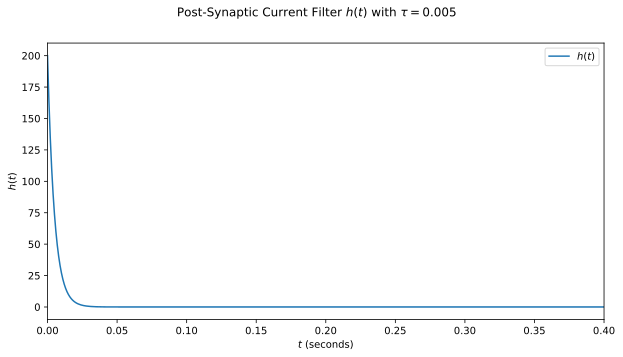

In [6]:
neuronCandidates = ensemble1.getNeuronsByRate(rateRange=[20,50], stim=0)

selectNeuron = np.random.choice(neuronCandidates)

override = {
    "xInt": selectNeuron.getIntercept(),
    "maxRate": selectNeuron.getMaxRate(),
    "encoder": selectNeuron.getEncoder(),
    "tauRef": selectNeuron.getTauRef(),
    "tauRc": selectNeuron.getTauRc(),
    "alpha": selectNeuron.getGain(),
    "jBias": selectNeuron.getBias(),
    "spikeTrend": selectNeuron.getSpikeTrend(),
    "firingRates": selectNeuron.getRates(),
}

neuron1 = Neuron(state=None, override=override)
neuron2 = Neuron(state=None, override=override)

neuron1.setEncoder(1)
neuron1.SetId(uuid4())
neuron2.setEncoder(-1)

# Create second ensemble of neurons with +1 and -1 encoders
ensemble2 = Population(state=None, neuronOverrides=[neuron1, neuron2])

# Set constants for computation
T = 1
dt = 1/1000
rms = 1
limit = 5

t = np.arange(0,T,dt)

xRandom, XRandom = generate_signal(T, dt, rms, limit, seed)

ensemble2.spike(xRandom, dt)

h, t_h = synaptic_filter(tau=5 / 1000, dt=dt, ms=T * 1000)


plt.figure(figsize=(10,5))
plt.suptitle("Post-Synaptic Current Filter $h(t)$ with $\\tau=0.005$")
plt.xlabel("$t$ (seconds)")
plt.ylabel("$h(t)$")
x1 = plt.plot(t_h, h, label="$h(t)$")
plt.legend(handles=[x1], labels=[])
plt.xlim([0, 0.4])
plt.show()

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

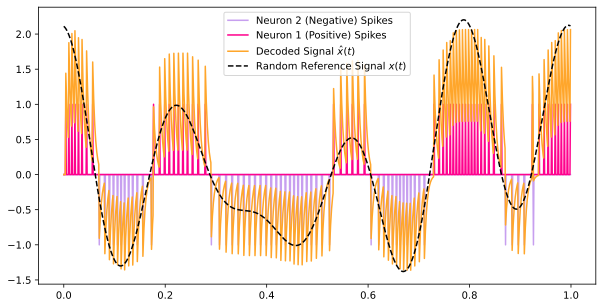

In [8]:
voltage_negative, numSpikes_negative, spikes_negative = neuron2.spikey(xRandom, dt)
voltage_positive, numSpikes_positive, spikes_positive = neuron1.spikey(xRandom, dt) 

r = 0

xHat = timedom_filter(h, spikes_negative, spikes_positive, xRandom, r)

plt.figure(figsize=(10,5))
plt.plot(t,spikes_negative, label="Neuron 2 (Negative) Spikes", color="xkcd:lavender")
plt.plot(t,spikes_positive, label="Neuron 1 (Positive) Spikes", color="xkcd:hot pink")
plt.plot(t,xHat.T, label="Decoded Signal $\hat x(t)$", color="xkcd:mango")
plt.plot(t, xRandom, label="Random Reference Signal $x (t)$", linestyle="dashed", color="black")

plt.legend()

**c) Error analysis.** Compute the RMSE of the decoding.

In [9]:
printBlock("RMSE value between Randomly generated signal and decoded signal: ", rmse(xRandom, xHat))

RMSE value between Randomly generated signal and decoded signal:  ----------
0.5358528523922533
-----------------


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

In [10]:
# Create Neuron sets

neuronSet = [8, 16, 32, 64, 128, 256]
numSets = len(neuronSet)

state = {

    "minRate": 100,
    "maxRate": 200,
    "encoder": [-1, 1],
    "tauRef": 2 / 1000,
    "tauRc": 20 / 1000,
    "minXInt": -2,
    "maxXInt": 2,
}

populations = []
for neurons in neuronSet:
    set = []
    for count in range(numSets):
        ensemble = Population(numNeurons=neurons, state=state)
        set.append(ensemble)
    populations.append(set)

h, t_h = synaptic_filter(tau=5/1000, dt=1/1000, ms=1000, T=1)

populationErrorSpike = []
for populationSet in populations:
    setSpike = []
    for idx, population in enumerate(populationSet):
        x,X = generate_signal(T,dt,rms,limit,seed)
        population.spike(x,dt)
        
        
        

#print(numSets)

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_18397/3066260239.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

✍ \<YOUR SOLUTION HERE\>

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ \<YOUR SOLUTION HERE\>

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [ ]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ \<YOUR SOLUTION HERE\>